### SETUP

<h3>Data</h3>
We will work on 2 Corpuses (or set of texts). All the texts or publicly available texts dealing with mutual funds. More precisely, the text has been extracted from the prospectuses of Mutual funds.
<ul>
  <li><u>MutualFundSummary</u><br>
      This file contains around 500 fund summaries in text files. A summary is the part of the prospectus that summaries the objective of the fund, the principal strategy, the decomposition of the fees, the principal risks that face the fund and some other information about the management of the fund.
  </li>
  <li><u>MutualFundLabels.csv</u><br>
      This table contains information about around 400 mutual funds. We will mostly focus on the "derivative" column that states whereas funds use derivatives or not. (the precise schema of the table is given later)
  </li>
  <li><u>FundArticlesHealthy.csv</u><br>
      Set of News Articles dealing with funds that contains valuable information such as target of the fund, closure date of the fund, present value of the fund... </br>
In order to build this dataset, we extracted from various financial news website (such as financial time, finance-CNBC, Wall street journal...) a set of articles that deals with Funds. Then we selected from this corpus the articles that contained certain specific information. Such information included but is not limited to new managers, expected return, closure date, Equity investment per Found, Name of the parent company.
  </li>
  <li><u>FundArticlesUnhealthy.csv</u><br>
      In this table we have all the news articles dealing with funds that was extracted from news websites but that doesn't contain any useful information.
  </li>
</ul>


In [1]:
# Install tensorflow 2 to the virtual environment.
!pip install "tensorflow>=2.15.0"
!pip install --upgrade tensorflow-hub

# Restart Runtime after installation !
# -> Runtime -> Restart Runtime...
# Rerun the cell when the runtime has restarted

In [2]:
# Uncomment if you aare using colab. Now we connect the colab notebook to our drive to access the data.
from google.colab import drive
drive.mount('/content/gdrive')
# Run the cell and follow the instructions

Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app

/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app


In [4]:
# Import the libraries

import os
import sys
from IPython.display import HTML, display

import numpy as np
import pandas as pd
import tensorflow as tf
from math import ceil
from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt
import seaborn as sns

import collections
import random
import time
import string
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Dense, Convolution1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dropout, LSTM, Bidirectional

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [5]:
print(tf.__version__)

2.15.0


In [203]:
DIRECTORY = '/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app'

SUMMARY_PATH = '/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app/MutualFundSummary'
SUMMARY_LABELS_PATH = '/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app/MutualFundLabels.csv'

HEALTHY_ARTICLES_PATH = os.path.join(DIRECTORY, "Data", "FundArticlesHealthy.csv")
UNHEALTHY_ARTICLES_PATH = os.path.join(DIRECTORY, "Data", "FundArticlesUnhealthy.csv")

glove_word2vec = 'glove.6B.50d.txt'
our_word2vec = 'word2vec_perso.txt'

### Util

Some useful func

In [7]:
# Progress bar
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Save a word2vec dictionary.
def save_word2vec(filename):
    #with open(os.path.join('/Users/haoxing/Documents/Work/Teaching/Machine learning for Finance/Codes/NLP/NLP_app', filename),'a' , encoding='utf-8') as f :
    with open(os.path.join('/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app/', filename),'a' , encoding='utf-8') as f :
        for k, v in word2vec.items():
            line = k+' '+str(list(v)).strip('[]').replace(',','')+'\n'
            f.write(line)

# Load a word2vec dictionary.
def load_word2vec(filename):
    word2vec = {}
    #with open(os.path.join('/Users/haoxing/Documents/Work/Teaching/Machine learning for Finance/Codes/NLP/NLP_app', filename), encoding='utf8') as f:
    with open(os.path.join('/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app/', filename), encoding='utf8') as f:
        for line in f:
            try :
                values = line.split()
                word = values[0]
                vec = np.asarray(values[1:], dtype='float32')
                word2vec[word] = vec
            except :
                None
    return word2vec

# read the repo in PATH and append the texts in a list
def get_data(PATH):
    list_dir = os.listdir(PATH)
    texts = []
    fund_names = []
    out = display(progress(0, len(list_dir)-1), display_id=True)
    for ii, filename in enumerate(list_dir) :
        with open(PATH+'/'+filename, 'r', encoding="utf8") as f :
            txt = f.read()
            try :
                txt_split = txt.split('<head_breaker>')
                summary = txt_split[1].strip()
                fund_name = txt_split[0].strip()
            except :
                summary = txt
                fund_name = ''
        texts.append(summary)
        fund_names.append(fund_name)
        out.update(progress(ii, len(list_dir)-1))
    return fund_names, texts

# A- ML Classification for summary detection

<b>Objective</b><br>
Imagine you are a big financial corporation; you receive thousands of new articles about funds every day and you need to know what these articles says. The easy but expensive solution is to have a team that read all the articles and fill excels with the import information. The other solution is NLP!<br>
In the following section we will work on the first piece of a framework aimed at extracting information from an unstructured feed of news article. Before implementing the actual extraction, we need to structure the data. By going through the data, you observe that half of the articles you receive are irrelevant to your buisness and does not contain any valuable information. Your first objective is to filter out these documents. <br>
As NLP expert you have been asked to create a text classifier that would automaticaly classify the articles that contains valuable information (the healthy documents) to the articles that don't (the unhealthy articles). <br>
In this section we create two ML text classifiers aimed at classifying the healty documents to the unhealthy documents.



### 1_ Read and format Data

We load the two classes of documents: the healthy and the unhealthy documents.

In [8]:
#df_healthy = pd.read_csv(HEALTHY_ARTICLES_PATH).sample(1000) # We reduce the size of the corpus to speed up the training
df_healthy = pd.read_csv('FundArticlesHealthy.csv').sample(1000)
healthy_articles = list(df_healthy['Healthy Fund Articles'].values)
#df_unhealthy = pd.read_csv(UNHEALTHY_ARTICLES_PATH).sample(1000)
df_unhealthy = pd.read_csv('FundArticlesUnhealthy.csv').sample(1000)
unhealthy_articles = list(df_unhealthy['Unhealthy Fund Articles'].values)

We create our corpus of text X and our target values y. The target of a summary is 1 and the target of a non-summary document is 0.

In [9]:
X = np.array(healthy_articles + unhealthy_articles)
y = np.concatenate((np.ones(len(healthy_articles)),np.zeros(len(unhealthy_articles))))

Split data in training and testing sets.<br>
30% of the data will be used to assess the performance of our classification. <br>
Setting random state allows to have the same split whenever we reload this cell. That way, we make sure to keep the test sample independent to the training.


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 2_ Preprocess the texts

Using Lemmatization to finish the goal of text normalization.

In [11]:
def lemma_tokenizer(text):
    lemmatizer=WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in word_tokenize(text.replace("'"," "))]

In the preceding cell we create a function that lemmatize and tokenize the text.<br>Tokenization is the act of breaking up a sequence of strings into pieces such as words, keywords, phrases, symbols and other elements called tokens.<br>
The <u>lemma_tokenizer</u> function takes a string text as input and output the list of lemmatized words of this text.<br>
Then we create our list of stop words that we want to remove from the texts.

In [12]:
stop_words = set(stopwords.words('english')+list(string.punctuation)+['``',"''"]+["]","[","*"]+['doe', 'ha', 'wa'])

### 2_ Create word vectors

In [13]:
max_features = 5000 # we will only consider the 5000 most frequent words to create the vectors.
# This value is the size of the vocabulary that we use to vectorize.

In [14]:
# Create the vectorizer object that will create the vectors.
tfidf = TfidfVectorizer(input='content', tokenizer=lemma_tokenizer, stop_words='english', max_features=max_features)
# The tfidf object use our lemma_tokenizer function and our stop_words list. It will clean the text while vectorizing it.

In [15]:
# Fits the tfidf vecotizer on the train sample and create the training features.
tfidf_train = tfidf.fit_transform(X_train)
# Uses the vectorizer to create the test features.
tfidf_test = tfidf.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


### 3_ First model : Multinomial naivebayes

In [16]:
# Set the parameteters
parameters = {'alpha': [1e-10, 1e-5, 1e-1, 0.5, 1, 2], 'fit_prior':[True, False]}

In [17]:
# Fit the grid search
NB = MultinomialNB()
classifierNB = GridSearchCV(NB, parameters, cv=2)
grid = classifierNB.fit(tfidf_train, y_train)

In [18]:
# Get the results of the grid search
print()
means = classifierNB.cv_results_['mean_test_score']
stds = classifierNB.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, classifierNB.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
        % (mean, std * 2, params))
print()


0.817 (+/-0.009) for {'alpha': 1e-10, 'fit_prior': True}
0.817 (+/-0.009) for {'alpha': 1e-10, 'fit_prior': False}
0.836 (+/-0.004) for {'alpha': 1e-05, 'fit_prior': True}
0.836 (+/-0.004) for {'alpha': 1e-05, 'fit_prior': False}
0.839 (+/-0.034) for {'alpha': 0.1, 'fit_prior': True}
0.839 (+/-0.034) for {'alpha': 0.1, 'fit_prior': False}
0.838 (+/-0.030) for {'alpha': 0.5, 'fit_prior': True}
0.838 (+/-0.030) for {'alpha': 0.5, 'fit_prior': False}
0.846 (+/-0.031) for {'alpha': 1, 'fit_prior': True}
0.845 (+/-0.030) for {'alpha': 1, 'fit_prior': False}
0.853 (+/-0.026) for {'alpha': 2, 'fit_prior': True}
0.853 (+/-0.023) for {'alpha': 2, 'fit_prior': False}



In [19]:
# Prediction
y_pred_NB = classifierNB.predict(tfidf_test)

In [20]:
# Confusion Matrix
confusion_matrix(y_test, y_pred_NB)

array([[240,  58],
       [ 36, 266]])

In [21]:
# Performance Report
print(classification_report(y_test, y_pred_NB))

              precision    recall  f1-score   support

         0.0       0.87      0.81      0.84       298
         1.0       0.82      0.88      0.85       302

    accuracy                           0.84       600
   macro avg       0.85      0.84      0.84       600
weighted avg       0.85      0.84      0.84       600



### 4_ Second model : Kernel SVM

In [22]:
# Create the SVM classifier with sklearn
classifierSVC = SVC(C=1, kernel = 'rbf', gamma=0.85, probability=True)
# Fit on training set
classifierSVC.fit(tfidf_train, y_train)

SVC(C=1, gamma=0.85, probability=True)

In [23]:
# Prediction
y_pred_SVC = classifierSVC.predict(tfidf_test)

In [24]:
# Confusion matrix
confusion_matrix(y_test, y_pred_SVC)

array([[273,  25],
       [ 52, 250]])

In [25]:
# Performance Report
print(classification_report(y_test, y_pred_SVC))

              precision    recall  f1-score   support

         0.0       0.84      0.92      0.88       298
         1.0       0.91      0.83      0.87       302

    accuracy                           0.87       600
   macro avg       0.87      0.87      0.87       600
weighted avg       0.87      0.87      0.87       600



# B- Word2vec a contextual vectoryzer

### 1_ Understand Context vectorisation

The word2vec skip-gram model is a deep learning model that allows to create for each word of a given set of documents a unique vector. These vectors are built such that two words that are used in the same context (context is defined here as the 3 to 5 words before and the 3 to 5 words after) are close in term of spatial distance.

### 2_ Read and format the data

We will train the word2vec skip-gram model on the summaries. <br>
First, we create a Tokenizer function that cleans and tokenize the summaries. The main difference with the pre-processing of the previous part is that we don't want to lemmatize the documents. All the different words of our corpus (except the stopwords and the special characters) will have its own vector. <br>



In [204]:
# Get the summaries
fund_names, summaries = get_data(SUMMARY_PATH)
# The reading function can take several minutes depending on your internet connection.
# The reading function store the data in the cache so that rerunning the cell should be must faster.

In [119]:
fund_names

['AB Arizona Portfolio',
 'AB Asia ex-Japan Equity Portfolio',
 'AB Bond Inflation Strategy',
 'AB Balanced Wealth Strategy Portfolio',
 'AB Credit Long/Short Portfolio',
 'AB All Market Income Portfolio',
 'AB All Market Real Return Portfolio',
 'AB Discovery Value Fund',
 'AB Dynamic Asset Allocation Portfolio',
 'AB FlexFee Emerging Markets Growth Portfolio',
 'AB FlexFee Core Opportunities Portfolio',
 'AB FlexFee International Strategic Core Portfolio',
 'AB Global Risk Allocation-Moderate Portfolio',
 'AB FlexFee Large Cap Growth Portfolio',
 'AB Global Thematic Growth Portfolio',
 'AB Income Fund',
 'AB Limited Duration High Income Portfolio',
 'AB Intermediate Bond Portfolio',
 'AB Minnesota Portfolio',
 'AB Massachusetts Portfolio',
 'AB Municipal Bond Inflation Strategy',
 'AB Tax-Aware Fixed Income Portfolio',
 'AB New York Portfolio',
 'AB New Jersey Portfolio',
 'AB Pennsylvania Portfolio',
 'AB Small Cap Value Portfolio',
 'AB Real Estate Investment Portfolio',
 'AB Small

The following tokenizer function takes a text as input. The function removes the stopwords, the tokens with no letters and returns a list of the remining tokens.

In [205]:
# clean and tokenize the text -> we don't want to lemmatize
def tokenizer(txt):
    txt = txt.replace('\n', ' ').replace('\t', ' ').lower()
    word_tokens = word_tokenize(txt)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = [w for w in filtered_sentence if re.sub("[^A-Za-z ]+",'',w) != '']
    return filtered_sentence

More cleaning could be done. We could for instance remove the tokens that have less than 3 letters or all the tokens that contains non-letter characters. <br>
Then we create one long list of tokens by tokenizing all the summaries with our "tokenizer" function and concatenating all the summaries.


In [206]:
text_words = np.concatenate([tokenizer(summary) for summary in summaries])

In [207]:
print(text_words[:20])

['ab' 'arizona' 'portfolio' 'investment' 'objective' 'investment'
 'objective' 'portfolio' 'earn' 'highest' 'level' 'current' 'income'
 'exempt' 'federal' 'income' 'tax' 'state' 'arizona' 'personal']


### 3_ Process Skip-Gram model Input

In [208]:
# Training Parameters
batch_size = 128 # The model will be trained batch per batch and one batch contains 128 rows
num_epochs = 2 # The model will go through all the data twice

* We set the dimension of our word vectors to 50. This is the embedding size and therefore the size of our hidden layer.
* We only consider the 5000 most frequent words.
* we set the window size to 3.
* Here we will only take 4 (num_skips) randomly chosen words in the local context of each word to build the input. (instead of all the local context as shown in the above example).


In [209]:
# Word2Vec Parameters
embedding_size = 50 # Dimension of the embedding vector
max_vocabulary_size = 5000 # Total number of different words in the vocabulary
min_occurrence = 10 # Remove all words that does not appears at least n times
skip_window = 3 # How many words to consider left and right
num_skips = 4 # How many times to reuse an input to generate a label

We start by building a dictionary that contains our vocabulary and the number of occurrences of each words : <u>count</u>

In [210]:
# Build the dictionary and replace rare words with UNK token
count = [('UNK', -1)]
# Retrieve the most common words
count.extend(collections.Counter(text_words).most_common(max_vocabulary_size - 1))
# Remove samples with less than 'min_occurrence' occurrences
for i in range(len(count) - 1, -1, -1):
    if count[i][1] < min_occurrence:
        count.pop(i)
    else:
        # The collection is ordered, so stop when 'min_occurrence' is reached
        break

Then, we give a unique id to each words in our vocabulary.

In [211]:
word2id = dict()
for i, (word, _)in enumerate(count):
    word2id[word] = i
id2word = dict(zip(word2id.values(), word2id.keys()))
vocab_size = len(id2word)

In [212]:
print ('size of the vocabulary : '+str(vocab_size))

size of the vocabulary : 3449


The length of the vocabulary corresponds to the 5000 most common words of our corpus minus the stop words. <br>
Then we create <u>data</u> which is simply the full tokenized corpus (text_words) where we filter out the words that are not in our vocabulary and we replace the actual words by their id.


In [213]:
# create data
data = list()
unk_count = 0
for word in text_words:
    # Retrieve a word id, or assign it index 0 ('UNK') if not in dictionary
    index = word2id.get(word, 0)
    if index == 0:
        unk_count += 1
    data.append(index)
count[0] = ('UNK', unk_count)

In [214]:
print(data[:20])

[1284, 0, 7, 3, 123, 3, 123, 7, 1085, 289, 471, 181, 26, 563, 77, 26, 61, 264, 0, 1087]


We create a function that translate a word index to its one-hot representation (vector of zero with 1 in the word id position)

In [130]:
# build OneHot vector from index
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

We are now ready to create the input of our model. <br>
The function <u>batch_generator</u> creates batches of 128 training rows that will be fed to our model. <br>
One raw is a couple (input, output) of one-hot word representations. An input vector is the one-hot representation of a word in our corpus and the associated output is the on-hot representation of one word in the local context of the input. <br>
The <u>batch_generator</u> function goes through our corpus (more precisely through <u>data</u>) and for each word, takes 4 (num_skips) words in its local context to create 4 rows. <br>
Ones 128 rows has been created (After 32 words), the function output a batch of these 128 rows and continue through the corpus. <br>
When all the corpus has been treated the function stops, we fed one epoch to the model.


In [131]:
# Generate training batch for the skip-gram model
def batch_generator(batch_size, num_skips, skip_window, vocab_size):
    data_index = 0
    while True :
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window
        # batch is filled with 128 inputs
        batch = np.ndarray(shape=(batch_size), dtype=np.int32)
        # labels is filled with 128 outputs
        labels = np.ndarray(shape=(batch_size), dtype=np.int32)
        span = 2 * skip_window + 1
        # buffer keep track of the visited indexes visited
        buffer = collections.deque(maxlen=span)
        if data_index + span > len(data):
            data_index = 0
            # We stop the loop when we went through all the corpus
            break
        buffer.extend(data[data_index:data_index + span])
        data_index += span
        for i in range(batch_size // num_skips):
            # Take the context current word
            context_words = [w for w in range(span) if w != skip_window]
            # Randomly select num_skips words in the context
            words_to_use = random.sample(context_words, num_skips)
            for j, context_word in enumerate(words_to_use):
                # Creates one raw data
                batch[i * num_skips + j] = buffer[skip_window]
                labels[i * num_skips + j] = buffer[context_word]
            if data_index == len(data):
                buffer.extend(data[0:span])
                data_index = span
            else:
                buffer.append(data[data_index])
                data_index += 1
        # Backtrack a little bit to avoid skipping words in the end of a batch
        data_index = (data_index + len(data) - span) % len(data)

        # translate word index to on-hot representation
        batch_one_hot = np.array([to_one_hot(b, vocab_size) for b in batch])
        labels_one_hot = np.array([to_one_hot(l, vocab_size) for l in labels])

        # output one batch
        yield batch_one_hot, labels_one_hot

### 4_ Train the skip-gram model
We are ready to create and train the model.

In [132]:
# Create en compile the Autoencoder
def creat_word2vec_model():
    input_word = Input(shape=(vocab_size,))

    encoded = Dense(embedding_size, activation='linear')(input_word)
    decoded = Dense(vocab_size, activation='softmax')(encoded)

    # The autoencoder is the whole model with hidden layer contected to the output layer.
    autoencoder = Model(input_word, decoded)
    # The encoder is just the input layer connected to the hidden layer. One the Autoencoder will be trained we will use
    # the encoder to create our word vectors
    encoder = Model(input_word, encoded)

    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return encoder, autoencoder

In [215]:
# We create the model
encoder, autoencoder = creat_word2vec_model()

In [216]:
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 3449)]            0         
                                                                 
 dense_18 (Dense)            (None, 50)                172500    
                                                                 
 dense_19 (Dense)            (None, 3449)              175899    
                                                                 
Total params: 348399 (1.33 MB)
Trainable params: 348399 (1.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [217]:
# Finally we can train the model by feeding it with our batch generator !
autoencoder.fit_generator(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)

Epoch 1/2


<ipython-input-217-872bc948d3d9>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  autoencoder.fit_generator(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)


7481/7481 [==============================] - 38s 5ms/step - loss: 0.0125
Epoch 2/2
7481/7481 [==============================] - 35s 5ms/step - loss: 0.0021


<h3>5_ Use the encoder to vectorize</h3><br>
The autoencoder has been trained, we can now use the matrix and bias of the encoder (input + hidden layer) to build our word representations !

In [218]:
# Create the Vectorizer function (prediciton of the encoder)
def vecotrize(word):
    word_one_hot = to_one_hot(word2id[word], vocab_size)
    return encoder.predict(np.array([word_one_hot]))[0]

In [219]:
# Create the word2vec dictionary
word2vec = {w : vecotrize(w) for w in word2id.keys()}

# This dictionary gives for all words it's vectorial representation.

1/1 [==============================] - 0s 21ms/step


In [220]:
# We can save the word2vec dictionary to reuse it later.
save_word2vec(our_word2vec)

<h3>6_Visualization</h3><br>
Now that we created our map, we can visualize the words!
We want to observe that words in the same context are spatially close.


<h5>a_ find the closer words</h5>

In [139]:
# for a given word, output the n closer words in the word2vec maping.
def get_n_closer(w, n, word2vec):
    vect = word2vec[w]
    distances_dict = {k: cosine(v, vect) for k, v in word2vec.items()}

    closer_words = []
    for _ in range(n):
        min_key = min(distances_dict.keys(), key=lambda k: distances_dict[k])
        closer_words.append(min_key)
        del distances_dict[min_key]
    return closer_words

In [221]:
fund_types_keywords = {
    "Balanced Fund (Low Risk)": ["balanced", "stable", "diversified"],
    "Fixed Income Long Only (Low Risk)": ["bonds", "fixed", "income"],
    "Equity Long Only (Low Risk)": ["equities", "stocks", "market"]
}
# Get closer words for each keyword
for fund_type, keywords in fund_types_keywords.items():
    print(f"--- {fund_type} ---")
    for keyword in keywords:
        closest_words = get_n_closer(keyword, 10, word2vec)
        print(f'Words close to {keyword}: {", ".join(closest_words)}')


--- Balanced Fund (Low Risk) ---
Words close to balanced: balanced, reimburse, fixed-income, cover, modifications, shall, independent, reduction, counsel, m.
Words close to stable: stable, pronounced, brokers, structures, systems, lines, midsize, issued, harder, activity
Words close to diversified: diversified, focus, valuation, geographic, continued, number, non-diversified, owned, series, maturity
--- Fixed Income Long Only (Low Risk) ---
Words close to bonds: bonds, asset-backed, lower-quality, developing, general, recessionary, basic, smaller, lessen, extension
Words close to fixed: fixed, asset-backed, reset, dramatically, floating, extension, slower-growth, arise, convertible, durations
Words close to income: income, tax, ordinary, marginal, reserve, board, endorsed, capital, gains, generally
--- Equity Long Only (Low Risk) ---
Words close to equities: equities, deductions, daily, reviews, us.allianzgi.com, transfers, treasury, way, unsettled, wesley
Words close to stocks: stocks

<h5>b_ plot closer words</h5>

We will use a TSNE model to reduce the word vectors to 2 dimensions. To learn more about the TSNE dimension reduction model I invite you to visit this link : https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding!

In [222]:
# fit the TSNE dimenstion reduction model
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
vectors = np.array([v for k, v in word2vec.items()])
words = np.array([k for k, v in word2vec.items()])
print(vectors.shape)

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
vectors = tsne_model.fit_transform(vectors)

print(vectors.shape)

(3449, 50)
(3449, 2)


In [224]:
reduced_word2vec = {words[i] : list(vectors[i]) for i in range (len(vectors))}

In [144]:
def create_neighbors_visualisation_data(words, num_neighbors, word2vec):
    words_neighbors = []
    for word in words :
        try :
            words_neighbors.append(get_n_closer(word, num_neighbors, word2vec))
        except :
            print(word +' not in word2vec')

    words_neighbors = np.concatenate(words_neighbors)
    vectors_neighbors = np.array([reduced_word2vec[word] for word in words_neighbors])

    return vectors_neighbors[:,0], vectors_neighbors[:,0], words_neighbors
x, y, labels = create_neighbors_visualisation_data(['fee', 'swaps'], 10, word2vec)

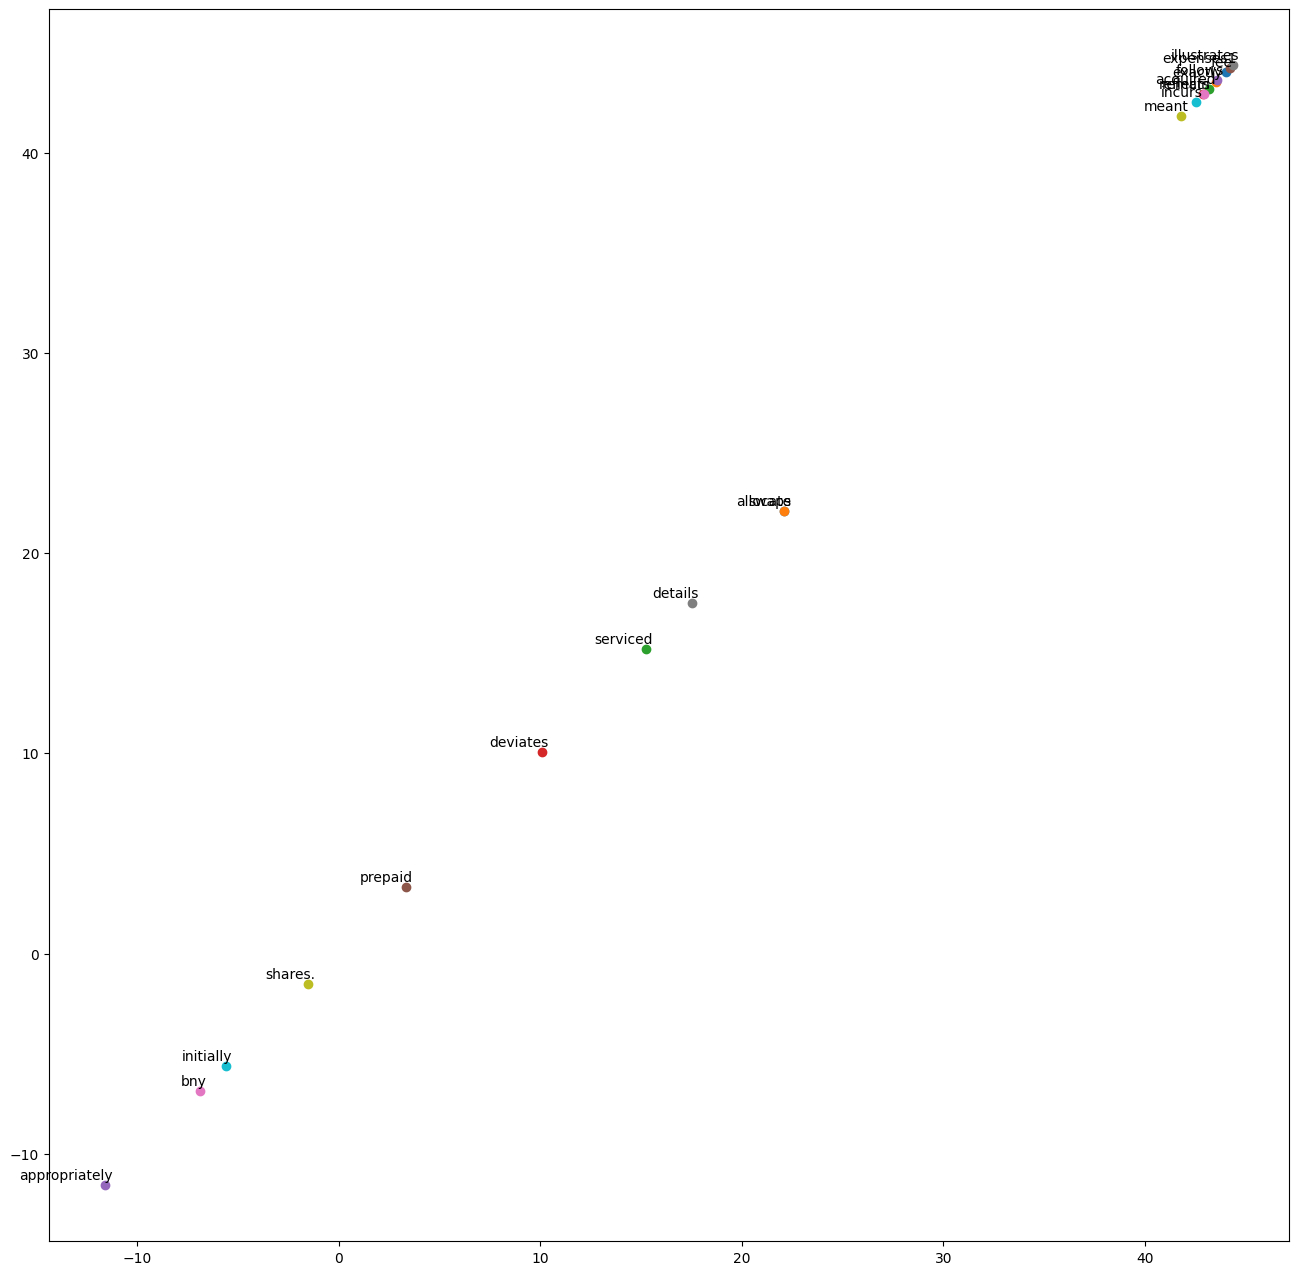

In [145]:
plt.figure(figsize=(16, 16))
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
        xy=(x[i], y[i]),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')
plt.show()

# C- Sentence extraction

<h3>Objective</h3>
Our objective for the next two parts is to create a model that will be able to predict the investment style of a mutual fund based on the summary.
The first step is to extract from the summaries the sentences that deals with the type of mutual fund.


<h3> 1_ Create a knowledge base </h3>

In [225]:
# Define initial keywords for each fund type
key_words_balanced = ['balanced', 'diversified', 'stable', 'stability', 'low', 'asset', 'conservative', 'allocation', 'mixed', 'mix', 'balance']
key_words_fixed_income = ['bonds', 'fixed', 'income', 'debt', 'secure', 'securities', 'corporate', 'low', 'government', 'yield', 'interest', 'treasury']
key_words_equity = ['equity', 'equities', 'share', 'shares', 'stocks', 'stock', 'markets', 'market', 'captial', 'growth']



In [226]:
word2vec = load_word2vec(glove_word2vec)

In [148]:
# Creates the knwoledge base by taking the num_neighbors closes neighbors of each key_words in word2vec
def create_knowledge_base(num_neighbors, word2vec, key_words):
    knowledge_base = set()
    out = display(progress(0, len(key_words)-1), display_id=True)
    for ii, key_word in enumerate(key_words) :
        knowledge_base.add(key_word)
        neighbors = []
        try :
            neighbors = get_n_closer(key_word, num_neighbors, word2vec)
        except :
            print(key_word + ' not in word2vec')

        knowledge_base.update(neighbors)

        out.update(progress(ii, len(key_words)-1))
    return knowledge_base

In [227]:
# Define how many neighbors you want to consider
num_neighbors = 5


knowledge_base_balanced = create_knowledge_base(5, word2vec, key_words_balanced)
knowledge_base_fixed_income = create_knowledge_base(5, word2vec, key_words_fixed_income)
knowledge_base_equity = create_knowledge_base(5, word2vec, key_words_equity)


balanced not in word2vec
diversified not in word2vec
stable not in word2vec
stability not in word2vec
low not in word2vec
asset not in word2vec
conservative not in word2vec
allocation not in word2vec
mixed not in word2vec
mix not in word2vec
balance not in word2vec


bonds not in word2vec
fixed not in word2vec
income not in word2vec
debt not in word2vec
secure not in word2vec
securities not in word2vec
corporate not in word2vec
low not in word2vec
government not in word2vec
yield not in word2vec
interest not in word2vec
treasury not in word2vec


equity not in word2vec
equities not in word2vec
share not in word2vec
shares not in word2vec
stocks not in word2vec
stock not in word2vec
markets not in word2vec
market not in word2vec
captial not in word2vec
growth not in word2vec


In [228]:
print(knowledge_base_balanced)
print(knowledge_base_fixed_income)
print(knowledge_base_equity)

{'mix', 'stable', 'allocation', 'balanced', 'low', 'mixed', 'conservative', 'diversified', 'stability', 'asset', 'balance'}
{'securities', 'fixed', 'income', 'debt', 'corporate', 'low', 'bonds', 'interest', 'secure', 'treasury', 'government', 'yield'}
{'growth', 'stocks', 'share', 'equities', 'market', 'equity', 'shares', 'captial', 'stock', 'markets'}


### 2_ Scoring function

In [229]:
# We create here the dataframe tha contains the summaries along with their labels
df_extraction = pd.DataFrame({'fund_name' : fund_names, 'summary':summaries})
df_label = pd.read_csv(SUMMARY_LABELS_PATH)
df = df_label.merge(df_extraction, on='fund_name', how='left')
df.head()

,id,fund_name,Performance fee?,Ivestment Strategy,Leverage?,Portfolio composition,Concentration,summary
0,0000051931-18-000151,American Funds College 2018 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2018 Fund\n\nInvestment...
1,0000051931-18-000151,American Funds College 2021 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2021 Fund\n\nInvestment...
2,0000051931-18-000151,American Funds College 2024 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2024 Fund\n\nInvestment...
3,0000051931-18-000151,American Funds College 2027 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2027 Fund\n\nInvestment...
4,0000051931-18-000151,American Funds College 2030 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2030 Fund\n\nInvestment...


In [230]:
df['summary'] = df['summary'].astype(str)

In [153]:
# Takes a summary, the knowledge base and some hyper parameters and returns the "num_sent" sentences
# of the summary that are closer to the the knowledge base in term of spacial distances.
def extract_sentence_distance(summary, knowledge, n_closer, n_reject, num_sent):
    # Split the summary into sentences.
    sentences = sent_tokenize(summary)
    sentence_scores = []
    # Loop over the sentences.
    for j, sentence in enumerate(sentences):
        # we tokenize and clean the sentence
        tokens = tokenizer(sentence)

        sentence_barycentre = np.zeros(embedding_size)
        effective_len = 0
        # Compute the barycentre of the sentence
        for token in tokens :
            try :
                sentence_barycentre += np.array(word2vec[token])
                effective_len += 1
            except KeyError :
                pass
            except :
                raise

        # Reject sentences with less than n_reject words in our word2vec map
        if effective_len <= n_reject :
            sentence_scores.append(1)

        else :
            sentence_barycentre = sentence_barycentre/effective_len
            # Compute the distance sentece_barycentre -> words in our knowledge base
            barycentre_distance = [cosine(sentence_barycentre, word2vec[key_word]) for key_word in knowledge]
            barycentre_distance.sort()
            # Create the score of the sentence by averaging the "n_closer" smallest distances
            score = np.mean(barycentre_distance[:n_closer])
            sentence_scores.append(score)
    # Select the "num_sent" sentences that have the smallest score (smallest distance score with the knowledge base)
    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[:num_sent]
    return ' '.join(top_sentences)

In [231]:
# It takes several minutes (5-10 minutes)
df['balanced_sentences_distance'] = df.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base_balanced, n_closer=10, n_reject=5, num_sent=5), axis=1)
df['fixed_income_sentences_distance'] = df.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base_fixed_income, n_closer=10, n_reject=5, num_sent=5), axis=1)
df['equity_sentences_distance'] = df.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base_equity, n_closer=10, n_reject=5, num_sent=5), axis=1)

<b>b_ Match extraction</b><br>
The second method is simply to count the number of words that are in the intersection of the knowledge base and the sentence.
This scoring function is highly dependent on the number of neighbours  chose to create the knowledge base.

In [155]:
def extract_sentence_match(summary, knowledge, num_sent):
    sentences = sent_tokenize(summary)
    sentence_scores = []
    for j, sentence in enumerate(sentences):
        set_tokens = set(tokenizer(sentence))

        # Find the number of common words between the knowledge base and the sentence
        inter_knwoledge = set_tokens.intersection(knowledge)

        sentence_scores.append(len(inter_knwoledge))

    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[len(sentences)-num_sent-1:]
    return ' '.join(top_sentences)

In [232]:
df['balanced_sentences_match'] = df.apply(lambda x: extract_sentence_match(x['summary'], knowledge_base_balanced, num_sent=5), axis=1)
df['fixed_income_sentences_match'] = df.apply(lambda x: extract_sentence_match(x['summary'], knowledge_base_fixed_income, num_sent=5), axis=1)
df['equity_sentences_match'] = df.apply(lambda x: extract_sentence_match(x['summary'], knowledge_base_equity, num_sent=5), axis=1)

# D_ Information extraction using deep classifiers

<b>Objective</b><br>
In this section we will use the sentences that we extracted in the previous section to train 2 deep learning models aimed at predicting if a mutual fund uses derivatives based on its summary.

<h3>1_ Format data</h3><br>
In this paragraph we will prepare the corpus, the dependent variable and split the data to a training set and a testing set. <br>
The independent variable (the corpus) is the list of the sentences extracted in the previous section for each fund.


## Blanced_fund


In [80]:
X = df['balanced_sentences_match'].values
# X = df['fixed_income_sentences_match'].values
# X = df['equity_sentences_match'].values

# X = df['balanced_sentences_distance'].values
# X = df['fixed_income_sentences_distance'].values
# X = df['equity_sentences_distance'].values

X = [' '.join(tokenizer(txt)) for txt in X]
X[0][:100]

'investment adviser also consider whether overall market conditions would favor change exposure fund '

In [81]:
y = df['Ivestment Strategy'].values

y = np.array([1 if x == 'Balanced Fund (Low Risk)' else 0 for x in y])





In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

<h3>2_ Data pre-processing</h3><br>

<ipython-input-83-975d4e36aab0>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sizes, kde=False, rug=True)


<Axes: >

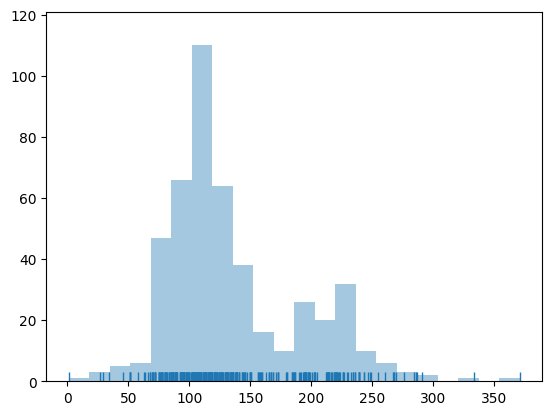

In [83]:
# In order to set the length of the document series (maxlen), we visualise the distribution of the number of words per documents.
sizes = []
out = display(progress(0, len(X)), display_id=True)
for ii, txt in enumerate(X):
    sizes.append(len(word_tokenize(txt)))
    out.update(progress(ii, len(X)))

sns.distplot(sizes, kde=False, rug=True)

First, we set the hyper parameters of the pre-processing phase.

In [84]:
num_words = 2500 # Size of the vocabulary used. we only consider the 2500 most common words. The other words are removed from the texts.
maxlen = 150 # Number of word considered for each document. we cut or lengthen the texts to have texts of 150 words.
word_dimension = 50 # dimension of our word vectors.

Then, we load the standford glove.6B.50d pretrained word2vec.

In [85]:
word2vec_g = load_word2vec(glove_word2vec)

In [86]:
# The Tokenizer provided by the Keras library allows to perform such transformation.
keras_tokenizer = Tokenizer(num_words=num_words)
keras_tokenizer.fit_on_texts(X_train)
# word_index is the dictionary that contains the index of each words in our 2500 long vocabulary.
word_index = keras_tokenizer.word_index
sequences_train = keras_tokenizer.texts_to_sequences(X_train)
sequences_test = keras_tokenizer.texts_to_sequences(X_test)

In [87]:
print('Text : '+X_train[0])
print('Index sequences : ' +str(sequences_train[0]))

Text : may also receive taxable distributions attributable fund 's sale municipal bonds may buy sell shares various ways internet institutional.fidelity.com phone reach fidelity representative mail fidelity investments p.o may qualify sales charge discounts family invest agree invest future least fund certain fidelity® funds result changes market value single investment could cause greater fluctuations share price would occur diversified fund addition fund considered non-diversified invest greater portion assets securities smaller number individual issuers diversified fund price buy one share class offering price pay front-end sales charge net asset value per share nav qualify front-end sales charge waiver
Index sequences : [2, 100, 429, 924, 329, 1122, 1, 33, 94, 184, 222, 2, 262, 129, 8, 211, 530, 581, 346, 110, 104, 582, 563, 110, 600, 138, 110, 36, 163, 131, 2, 153, 24, 28, 309, 185, 34, 203, 34, 197, 124, 1, 78, 738, 7, 165, 145, 15, 6, 212, 5, 53, 88, 54, 159, 59, 21, 101, 739, 2

In [88]:
feature_train = pad_sequences(sequences_train, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_test = pad_sequences(sequences_test, maxlen=maxlen, dtype=float, padding='post', truncating='post')

In [89]:
print ('length of the first sequence : '+str(len(sequences_train[0])) )
print ('length of the paded first sequence : '+str(len(feature_train[0])) )

length of the first sequence : 101
length of the paded first sequence : 150


In [90]:
embedding_matrix = np.zeros((len(word_index) + 1, word_dimension))
for word, i in word_index.items():
    embedding_vector = word2vec_g.get(word)
    #embedding_vector = word2vec.get(word)   # uncomment to use our own word2vec
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [91]:
embedding_matrix[2]

array([ 0.70480001,  0.22261   ,  0.086997  , -0.21241   , -0.089356  ,
        0.43742001, -0.28169999,  0.13378   , -0.50858998, -0.18242   ,
        0.49506   ,  0.42460999,  0.046785  , -0.50120997,  0.84621   ,
        1.01460004, -0.43954   , -0.65499002, -0.64705998, -0.23365   ,
        0.27612001, -0.63293999,  0.91064   ,  0.033327  , -0.058451  ,
       -1.60590005, -0.34740999, -0.36285001,  0.46722999,  0.244     ,
        3.42490005,  0.056168  , -0.71991003, -0.88331997,  0.33741   ,
       -0.53236002,  0.33991   ,  0.023837  ,  0.2384    , -0.38712999,
       -0.49621001, -0.14846   ,  0.046201  ,  0.10325   ,  0.17374   ,
        0.13763   ,  0.084989  , -0.39688   ,  0.17632   ,  0.31862   ])

In [92]:
embedding_matrix.shape

(2168, 50)

In [93]:
len(word_index) + 1

2168

In [94]:
word_dimension

50

<h3>3_ First Model : One dimensional Convolutional Neural Network</h3>

In [95]:
def create_CNN_model():
    CNN = Sequential()
    # The Embedding layer takes the embedding matrix as an argument and transform the inputed the sequences of index to sequences of vectors.
    CNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length=maxlen, trainable=False))

    CNN.add(Convolution1D(64, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Convolution1D(32, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Flatten())
    CNN.add(Dense(units = 128 , activation = 'relu'))
    CNN.add(Dropout(0.5))
    CNN.add(Dense(units = 1, activation = 'sigmoid'))

    CNN.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

    return CNN

In [96]:
CNN_model = create_CNN_model()

In [97]:
CNN_history = CNN_model.fit(feature_train, y_train, epochs=10, batch_size=16, validation_data=(feature_test, y_test))

Epoch 1/10
24/24 [==============================] - 5s 33ms/step - loss: 0.5319 - accuracy: 0.7721 - val_loss: 0.3415 - val_accuracy: 0.8617
Epoch 2/10
24/24 [==============================] - 0s 5ms/step - loss: 0.3471 - accuracy: 0.8633 - val_loss: 0.2654 - val_accuracy: 0.9362
Epoch 3/10
24/24 [==============================] - 0s 6ms/step - loss: 0.2387 - accuracy: 0.9088 - val_loss: 0.2190 - val_accuracy: 0.9255
Epoch 4/10
24/24 [==============================] - 0s 6ms/step - loss: 0.1469 - accuracy: 0.9437 - val_loss: 0.1967 - val_accuracy: 0.9255
Epoch 5/10
24/24 [==============================] - 0s 5ms/step - loss: 0.1109 - accuracy: 0.9651 - val_loss: 0.2026 - val_accuracy: 0.9255
Epoch 6/10
24/24 [==============================] - 0s 5ms/step - loss: 0.0854 - accuracy: 0.9625 - val_loss: 0.1911 - val_accuracy: 0.9468
Epoch 7/10
24/24 [==============================] - 0s 5ms/step - loss: 0.0582 - accuracy: 0.9786 - val_loss: 0.2791 - val_accuracy: 0.9468
Epoch 8/10
24/24 [=

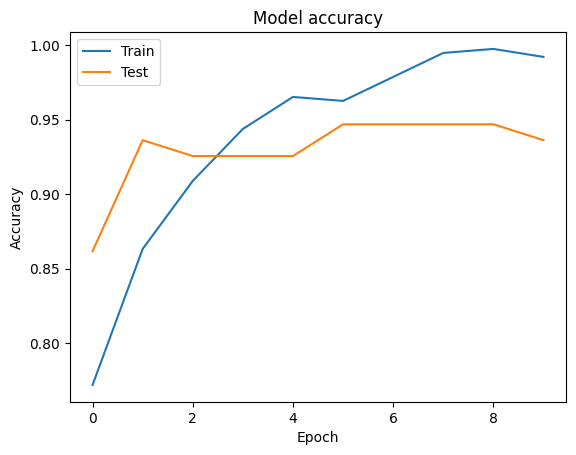

In [98]:
# Plot training & validation accuracy
plt.plot(CNN_history.history['accuracy'])
plt.plot(CNN_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

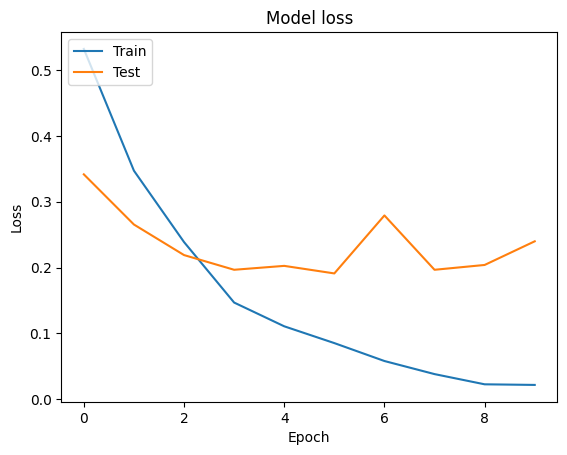

In [99]:
# Plot training & validation loss values
plt.plot(CNN_history.history['loss'])
plt.plot(CNN_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


<b>b_ Evalutation</b>



#### ROC_curve

In [100]:
y_pred_CNN = CNN_model.predict(feature_test)

3/3 [==============================] - 0s 25ms/step


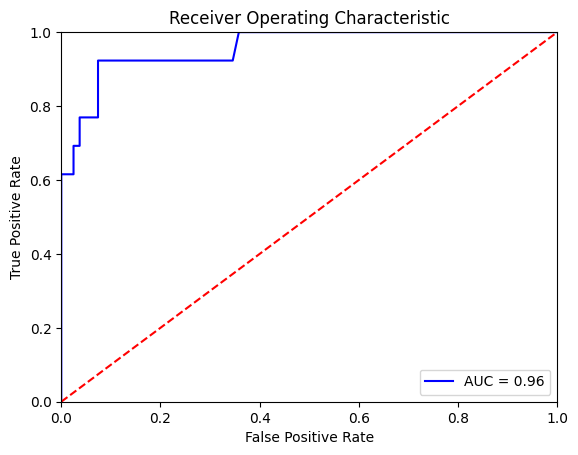

In [101]:
fpr, tpr, threshold =roc_curve(y_test, y_pred_CNN)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<h3>4_ Second Model : Recurrent Neural Networks</h3>

In [102]:
def create_RNN_model():
    RNN = Sequential()
    RNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))

    RNN.add(Bidirectional(LSTM(word_dimension)))
    RNN.add(Dense(word_dimension, activation='relu'))
    RNN.add(Dense(1, activation='sigmoid'))
    RNN.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

    return RNN

In [103]:
RNN_model = create_RNN_model()

In [104]:
RNN_history = RNN_model.fit(feature_train, y_train, epochs=10, batch_size=16, validation_data=(feature_test, y_test))

Epoch 1/10
24/24 [==============================] - 5s 49ms/step - loss: 0.4811 - accuracy: 0.8097 - val_loss: 0.3568 - val_accuracy: 0.8617
Epoch 2/10
24/24 [==============================] - 0s 15ms/step - loss: 0.3904 - accuracy: 0.8097 - val_loss: 0.2814 - val_accuracy: 0.8617
Epoch 3/10
24/24 [==============================] - 0s 14ms/step - loss: 0.2925 - accuracy: 0.8767 - val_loss: 0.2897 - val_accuracy: 0.8830
Epoch 4/10
24/24 [==============================] - 0s 14ms/step - loss: 0.2373 - accuracy: 0.9062 - val_loss: 0.1415 - val_accuracy: 0.9574
Epoch 5/10
24/24 [==============================] - 0s 15ms/step - loss: 0.2129 - accuracy: 0.9249 - val_loss: 0.1449 - val_accuracy: 0.9468
Epoch 6/10
24/24 [==============================] - 0s 14ms/step - loss: 0.1939 - accuracy: 0.9330 - val_loss: 0.1861 - val_accuracy: 0.9149
Epoch 7/10
24/24 [==============================] - 0s 14ms/step - loss: 0.1689 - accuracy: 0.9410 - val_loss: 0.1150 - val_accuracy: 0.9787
Epoch 8/10
24

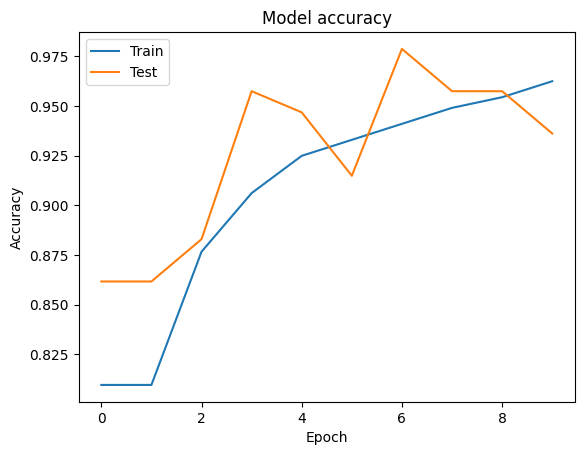

In [105]:
# Plot training & validation accuracy values
plt.plot(RNN_history.history['accuracy'])
plt.plot(RNN_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

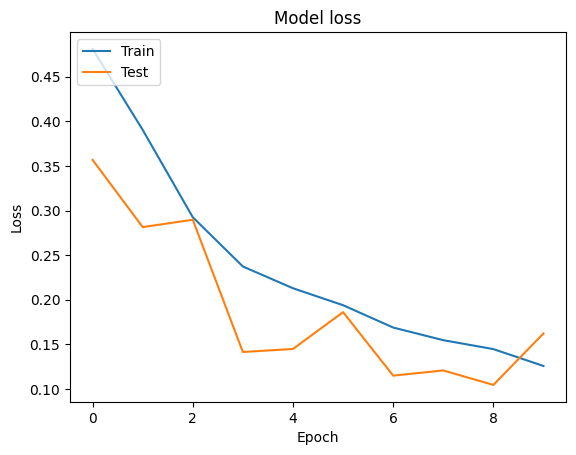

In [106]:
# Plot training & validation loss values
plt.plot(RNN_history.history['loss'])
plt.plot(RNN_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

<b>b_ Evaluation</b>

In [107]:
y_pred_RNN = RNN_model.predict(feature_test)

3/3 [==============================] - 1s 7ms/step


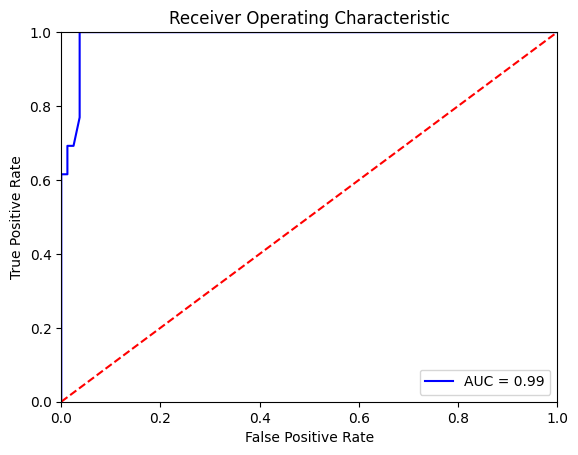

In [108]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_RNN)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Fixed_Income_fund

In [157]:
# X = df['balanced_sentences_match'].values
X = df['fixed_income_sentences_match'].values
# X = df['equity_sentences_match'].values

# X = df['balanced_sentences_distance'].values
# X = df['fixed_income_sentences_distance'].values
# X = df['equity_sentences_distance'].values

X = [' '.join(tokenizer(txt)) for txt in X]
X[0][:100]

'bonds debt securities also subject credit risk possibility credit strength issuer weaken and/or issu'

In [158]:
y = df['Ivestment Strategy'].values

y = np.array([1 if x == 'Fixed Income Long Only (Low Risk)' else 0 for x in y])


In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

<ipython-input-160-975d4e36aab0>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sizes, kde=False, rug=True)


<Axes: >

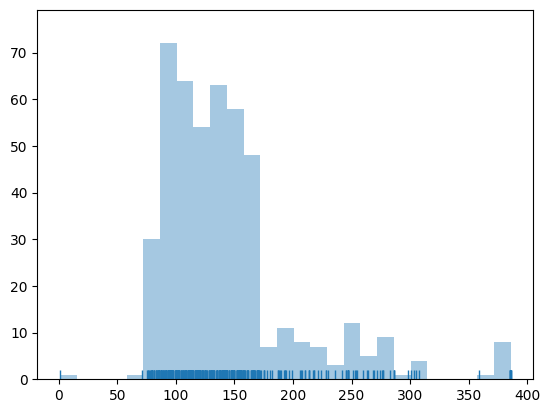

In [160]:
# In order to set the length of the document series (maxlen), we visualise the distribution of the number of words per documents.
sizes = []
out = display(progress(0, len(X)), display_id=True)
for ii, txt in enumerate(X):
    sizes.append(len(word_tokenize(txt)))
    out.update(progress(ii, len(X)))

sns.distplot(sizes, kde=False, rug=True)

In [161]:
num_words = 2500 # Size of the vocabulary used. we only consider the 2500 most common words. The other words are removed from the texts.
maxlen = 150 # Number of word considered for each document. we cut or lengthen the texts to have texts of 150 words.
word_dimension = 50 # dimension of our word vectors.

In [162]:
word2vec_g = load_word2vec(glove_word2vec)

In [163]:
# The Tokenizer provided by the Keras library allows to perform such transformation.
keras_tokenizer = Tokenizer(num_words=num_words)
keras_tokenizer.fit_on_texts(X_train)
# word_index is the dictionary that contains the index of each words in our 2500 long vocabulary.
word_index = keras_tokenizer.word_index
sequences_train = keras_tokenizer.texts_to_sequences(X_train)
sequences_test = keras_tokenizer.texts_to_sequences(X_test)

In [164]:
print('Text : '+X_train[0])
print('Index sequences : ' +str(sequences_train[0]))

Text : municipal market volatile significantly affected adverse tax legislative political changes financial condition issuers municipal securities payments may create conflict interest influencing intermediary investment professional recommend fund another investment may also receive taxable distributions attributable fund 's sale municipal bonds interest rate increases cause price debt security decrease unlike individual debt securities typically pay principal maturity value investment fund fluctuate principal investment strategies normally investing least assets investment-grade municipal securities whose interest exempt federal income tax may subject federal alternative minimum tax
Index sequences : [76, 11, 89, 342, 141, 160, 18, 630, 51, 15, 87, 885, 63, 76, 1, 33, 3, 73, 72, 4, 66, 70, 8, 326, 71, 2, 65, 8, 3, 49, 254, 213, 152, 818, 2, 62, 316, 76, 14, 4, 16, 255, 106, 25, 5, 23, 181, 655, 145, 5, 1, 210, 137, 28, 104, 24, 8, 2, 287, 28, 8, 176, 264, 22, 142, 40, 8, 100, 76, 1, 

In [166]:
feature_train = pad_sequences(sequences_train, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_test = pad_sequences(sequences_test, maxlen=maxlen, dtype=float, padding='post', truncating='post')
print ('length of the first sequence : '+str(len(sequences_train[0])) )
print ('length of the paded first sequence : '+str(len(feature_train[0])) )

length of the first sequence : 82
length of the paded first sequence : 150


In [167]:
embedding_matrix = np.zeros((len(word_index) + 1, word_dimension))
for word, i in word_index.items():
    embedding_vector = word2vec_g.get(word)
    #embedding_vector = word2vec.get(word)   # uncomment to use our own word2vec
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_matrix[2]

array([ 1.00660002,  0.55454999,  0.37957001, -0.26662999,  0.53280997,
       -0.19863001, -0.60299999, -0.89529002,  0.51981997,  0.087293  ,
       -0.62620997,  0.79895997,  0.064254  , -0.31514999,  0.37417001,
       -0.22691   ,  0.88391   , -0.0039159 ,  0.15341   ,  0.39658001,
        1.16489995, -0.47106999, -0.37327999, -1.10699999, -1.01670003,
       -1.1293    ,  0.13462   , -0.61711001, -1.1099    ,  0.23010001,
        3.01440001,  0.65491003,  0.10648   , -0.18189   , -0.91856003,
       -0.23679   , -0.79084998, -0.266     ,  0.95587999, -1.25020003,
       -0.62883002, -0.38758001,  0.20412   ,  0.21826001, -0.32853001,
       -0.92975998, -0.75106001,  0.69673002,  0.10138   ,  0.81498998])

In [168]:
embedding_matrix.shape

(2044, 50)

In [169]:
len(word_index) + 1

2044

In [170]:
word_dimension

50

#### CNN

In [171]:
CNN_model = create_CNN_model()

In [172]:
CNN_history = CNN_model.fit(feature_train, y_train, epochs=10, batch_size=16, validation_data=(feature_test, y_test))

Epoch 1/10
24/24 [==============================] - 2s 14ms/step - loss: 0.5596 - accuracy: 0.7131 - val_loss: 0.5632 - val_accuracy: 0.7234
Epoch 2/10
24/24 [==============================] - 0s 6ms/step - loss: 0.4274 - accuracy: 0.8123 - val_loss: 0.4752 - val_accuracy: 0.8085
Epoch 3/10
24/24 [==============================] - 0s 6ms/step - loss: 0.2769 - accuracy: 0.8820 - val_loss: 0.3885 - val_accuracy: 0.8511
Epoch 4/10
24/24 [==============================] - 0s 6ms/step - loss: 0.2281 - accuracy: 0.9088 - val_loss: 0.3120 - val_accuracy: 0.8085
Epoch 5/10
24/24 [==============================] - 0s 5ms/step - loss: 0.2333 - accuracy: 0.8981 - val_loss: 0.3904 - val_accuracy: 0.8404
Epoch 6/10
24/24 [==============================] - 0s 5ms/step - loss: 0.1229 - accuracy: 0.9705 - val_loss: 0.3123 - val_accuracy: 0.8085
Epoch 7/10
24/24 [==============================] - 0s 6ms/step - loss: 0.0803 - accuracy: 0.9759 - val_loss: 0.3486 - val_accuracy: 0.8085
Epoch 8/10
24/24 [=

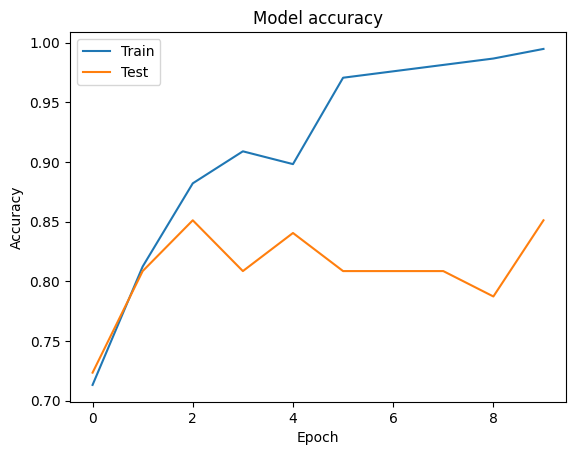

In [173]:
# Plot training & validation accuracy
plt.plot(CNN_history.history['accuracy'])
plt.plot(CNN_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

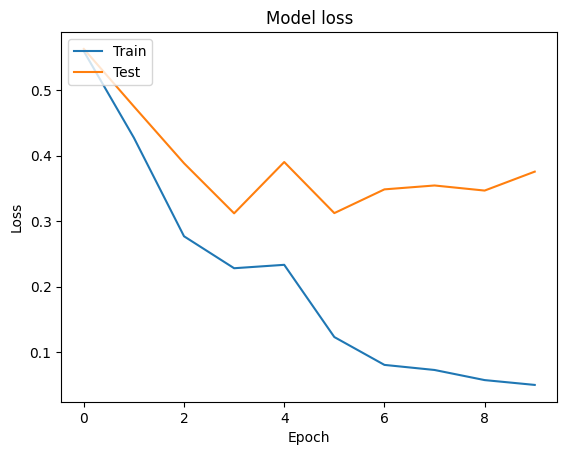

In [174]:
# Plot training & validation loss values
plt.plot(CNN_history.history['loss'])
plt.plot(CNN_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [175]:
y_pred_CNN = CNN_model.predict(feature_test)

3/3 [==============================] - 0s 3ms/step


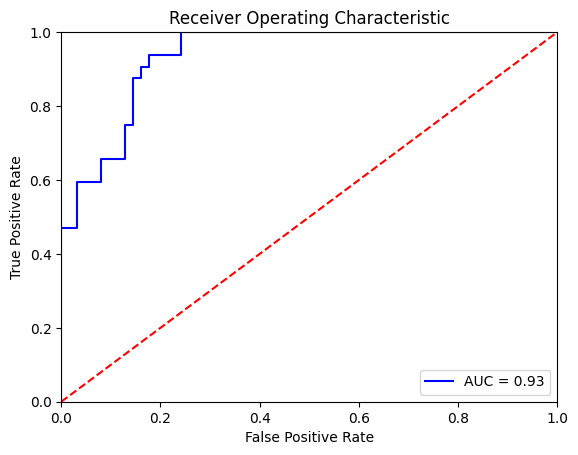

In [176]:
fpr, tpr, threshold =roc_curve(y_test, y_pred_CNN)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### RNN

In [178]:
RNN_model = create_RNN_model()
RNN_history = RNN_model.fit(feature_train, y_train, epochs=10, batch_size=16, validation_data=(feature_test, y_test))

Epoch 1/10
24/24 [==============================] - 5s 50ms/step - loss: 0.5667 - accuracy: 0.7373 - val_loss: 0.6346 - val_accuracy: 0.6596
Epoch 2/10
24/24 [==============================] - 0s 15ms/step - loss: 0.4874 - accuracy: 0.7641 - val_loss: 0.5607 - val_accuracy: 0.7128
Epoch 3/10
24/24 [==============================] - 0s 15ms/step - loss: 0.3835 - accuracy: 0.8338 - val_loss: 0.5516 - val_accuracy: 0.7340
Epoch 4/10
24/24 [==============================] - 0s 15ms/step - loss: 0.3350 - accuracy: 0.8606 - val_loss: 0.3795 - val_accuracy: 0.8298
Epoch 5/10
24/24 [==============================] - 0s 15ms/step - loss: 0.2516 - accuracy: 0.8981 - val_loss: 0.4200 - val_accuracy: 0.8191
Epoch 6/10
24/24 [==============================] - 0s 15ms/step - loss: 0.2178 - accuracy: 0.9142 - val_loss: 0.7023 - val_accuracy: 0.7340
Epoch 7/10
24/24 [==============================] - 0s 15ms/step - loss: 0.2680 - accuracy: 0.8820 - val_loss: 0.4377 - val_accuracy: 0.7766
Epoch 8/10
24

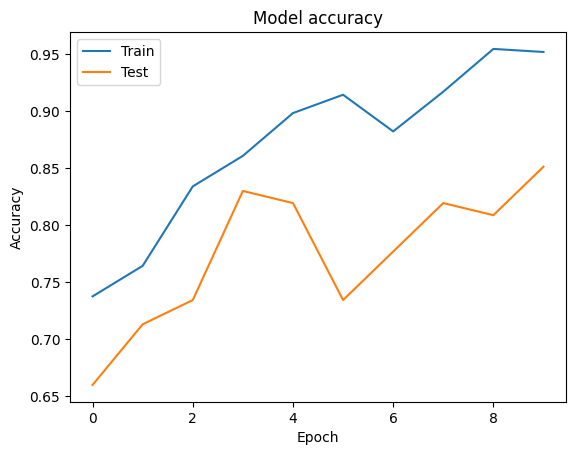

In [179]:
# Plot training & validation accuracy values
plt.plot(RNN_history.history['accuracy'])
plt.plot(RNN_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

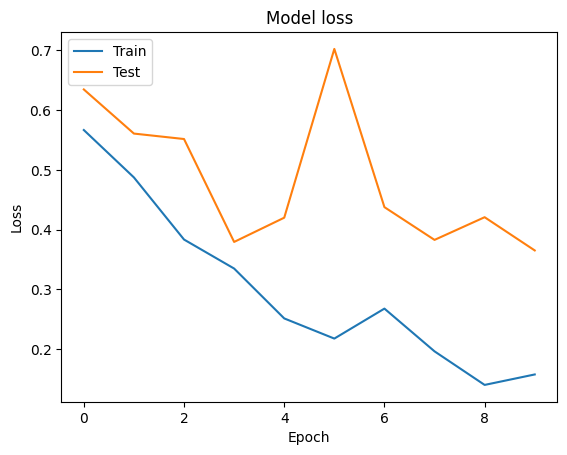

In [180]:
# Plot training & validation loss values
plt.plot(RNN_history.history['loss'])
plt.plot(RNN_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

3/3 [==============================] - 1s 7ms/step


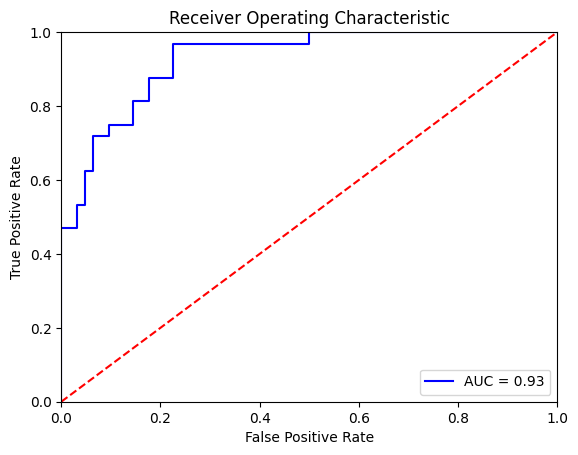

In [181]:
y_pred_RNN = RNN_model.predict(feature_test)
fpr, tpr, threshold = roc_curve(y_test, y_pred_RNN)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Equity fund

In [233]:
# X = df['balanced_sentences_match'].values
# X = df['fixed_income_sentences_match'].values
X = df['equity_sentences_match'].values

# X = df['balanced_sentences_distance'].values
# X = df['fixed_income_sentences_distance'].values
# X = df['equity_sentences_distance'].values

X = [' '.join(tokenizer(txt)) for txt in X]
X[0][:100]

'although actual costs may higher lower based assumptions costs would share class 529-a 529-c 529-e 5'

In [234]:
y = df['Ivestment Strategy'].values
y = np.array([1 if x == 'Equity Long Only (Low Risk)' else 0 for x in y])

In [235]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

<ipython-input-236-975d4e36aab0>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sizes, kde=False, rug=True)


<Axes: >

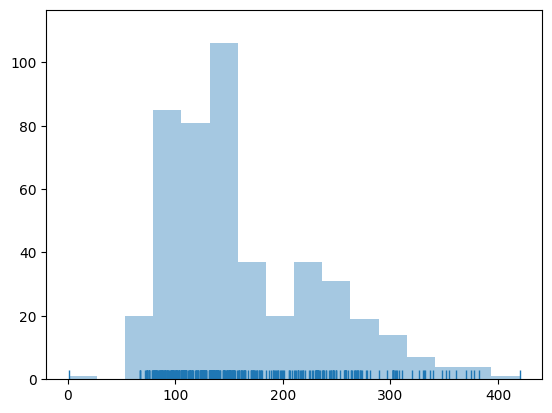

In [236]:
# In order to set the length of the document series (maxlen), we visualise the distribution of the number of words per documents.
sizes = []
out = display(progress(0, len(X)), display_id=True)
for ii, txt in enumerate(X):
    sizes.append(len(word_tokenize(txt)))
    out.update(progress(ii, len(X)))

sns.distplot(sizes, kde=False, rug=True)

In [237]:
num_words = 2500 # Size of the vocabulary used. we only consider the 2500 most common words. The other words are removed from the texts.
maxlen = 150 # Number of word considered for each document. we cut or lengthen the texts to have texts of 150 words.
word_dimension = 50 # dimension of our word vectors.

In [238]:
word2vec_g = load_word2vec(glove_word2vec)

In [239]:
# The Tokenizer provided by the Keras library allows to perform such transformation.
keras_tokenizer = Tokenizer(num_words=num_words)
keras_tokenizer.fit_on_texts(X_train)
# word_index is the dictionary that contains the index of each words in our 2500 long vocabulary.
word_index = keras_tokenizer.word_index
sequences_train = keras_tokenizer.texts_to_sequences(X_train)
sequences_test = keras_tokenizer.texts_to_sequences(X_test)

print('Text : '+X_train[0])
print('Index sequences : ' +str(sequences_train[0]))

Text : price sell one share class nav minus applicable contingent deferred sales charge cdsc price sell one share class nav value individual security particular type security volatile perform differently market whole purchase minimum class class shares may buy sell shares various ways internet institutional.fidelity.com phone reach fidelity representative mail fidelity investments p.o result changes market value single investment could cause greater fluctuations share price would occur diversified fund
Index sequences : [28, 96, 318, 18, 5, 41, 1409, 121, 255, 188, 47, 62, 314, 28, 96, 318, 18, 5, 41, 13, 319, 189, 127, 425, 189, 57, 106, 166, 2, 267, 32, 138, 5, 5, 3, 4, 224, 96, 3, 84, 459, 539, 169, 322, 361, 650, 552, 322, 651, 337, 322, 51, 163, 435, 286, 49, 2, 13, 607, 7, 153, 217, 146, 315, 18, 28, 353, 713, 777, 1]


In [240]:
feature_train = pad_sequences(sequences_train, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_test = pad_sequences(sequences_test, maxlen=maxlen, dtype=float, padding='post', truncating='post')
print ('length of the first sequence : '+str(len(sequences_train[0])) )
print ('length of the paded first sequence : '+str(len(feature_train[0])) )

length of the first sequence : 70
length of the paded first sequence : 150


In [257]:
embedding_matrix = np.zeros((len(word_index) + 1, word_dimension))
for word, i in word_index.items():
    # embedding_vector = word2vec_g.get(word)
    embedding_vector = word2vec.get(word)   # uncomment to use our own word2vec
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_matrix[2]

array([-0.0093193 , -0.72786999,  0.46830001,  0.29756001,  0.42387   ,
       -0.98396999, -0.80987   , -1.01719999, -0.012549  ,  0.72707999,
        0.34808999, -0.066407  , -0.60332   , -0.18149   ,  0.14071999,
        1.21220005, -0.30228999, -0.16802999, -0.26368999, -0.60948998,
        1.54260004, -0.58741999, -0.7123    ,  0.078042  , -0.26745999,
       -1.3635    , -0.27867001,  0.30660999,  0.60557997,  0.84930003,
        3.77640009,  0.28187001,  1.29760003,  0.13246   , -0.082881  ,
       -1.14960003, -1.03789997,  0.24816   ,  0.31573001, -0.52776998,
       -0.65205997, -0.013762  ,  0.34965   ,  0.030161  ,  0.82582003,
        0.25492999,  0.088389  ,  0.38069001,  0.84201998,  0.38185   ])

In [258]:
embedding_matrix.shape

(2234, 50)

In [259]:
len(word_index) + 1

2234

In [260]:
word_dimension

50

#### CNN

In [261]:
CNN_model = create_CNN_model()

In [262]:
CNN_history = CNN_model.fit(feature_train, y_train, epochs=10, batch_size=16, validation_data=(feature_test, y_test))

Epoch 1/10
24/24 [==============================] - 2s 13ms/step - loss: 0.7027 - accuracy: 0.5818 - val_loss: 0.6707 - val_accuracy: 0.5319
Epoch 2/10
24/24 [==============================] - 0s 5ms/step - loss: 0.5888 - accuracy: 0.7131 - val_loss: 0.6131 - val_accuracy: 0.6809
Epoch 3/10
24/24 [==============================] - 0s 5ms/step - loss: 0.4592 - accuracy: 0.8016 - val_loss: 0.5579 - val_accuracy: 0.6915
Epoch 4/10
24/24 [==============================] - 0s 5ms/step - loss: 0.3186 - accuracy: 0.8767 - val_loss: 0.4842 - val_accuracy: 0.7128
Epoch 5/10
24/24 [==============================] - 0s 6ms/step - loss: 0.2118 - accuracy: 0.9437 - val_loss: 0.4744 - val_accuracy: 0.7872
Epoch 6/10
24/24 [==============================] - 0s 5ms/step - loss: 0.1513 - accuracy: 0.9598 - val_loss: 0.4570 - val_accuracy: 0.7660
Epoch 7/10
24/24 [==============================] - 0s 5ms/step - loss: 0.0804 - accuracy: 0.9866 - val_loss: 0.4407 - val_accuracy: 0.8085
Epoch 8/10
24/24 [=

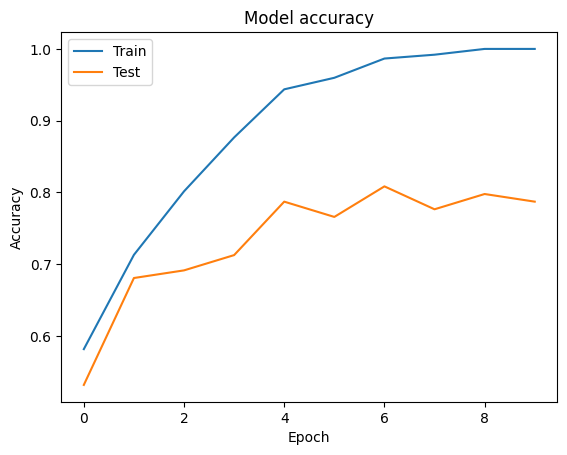

In [263]:
# Plot training & validation accuracy
plt.plot(CNN_history.history['accuracy'])
plt.plot(CNN_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

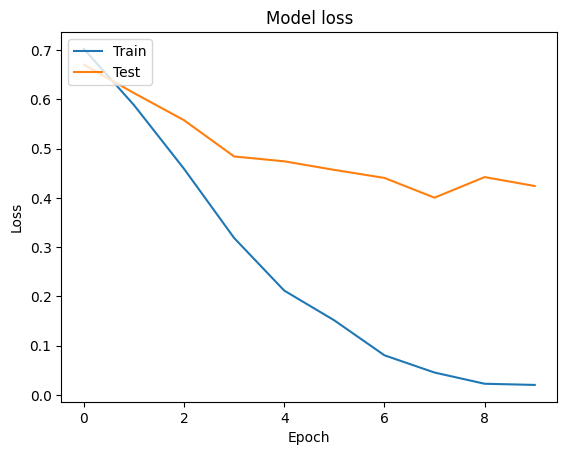

In [264]:
# Plot training & validation loss values
plt.plot(CNN_history.history['loss'])
plt.plot(CNN_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

3/3 [==============================] - 0s 3ms/step


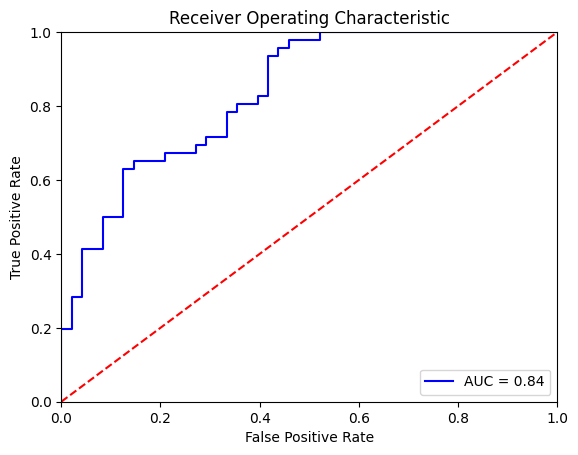

In [249]:
y_pred_CNN = CNN_model.predict(feature_test)
fpr, tpr, threshold =roc_curve(y_test, y_pred_CNN)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### RNN

In [250]:
RNN_model = create_RNN_model()
RNN_history = RNN_model.fit(feature_train, y_train, epochs=10, batch_size=16, validation_data=(feature_test, y_test))

Epoch 1/10
24/24 [==============================] - 4s 47ms/step - loss: 0.6697 - accuracy: 0.5737 - val_loss: 0.6684 - val_accuracy: 0.5532
Epoch 2/10
24/24 [==============================] - 0s 14ms/step - loss: 0.6034 - accuracy: 0.7105 - val_loss: 0.6588 - val_accuracy: 0.5851
Epoch 3/10
24/24 [==============================] - 0s 14ms/step - loss: 0.5301 - accuracy: 0.7426 - val_loss: 0.5981 - val_accuracy: 0.7021
Epoch 4/10
24/24 [==============================] - 0s 14ms/step - loss: 0.4953 - accuracy: 0.7507 - val_loss: 0.6447 - val_accuracy: 0.6170
Epoch 5/10
24/24 [==============================] - 0s 14ms/step - loss: 0.4290 - accuracy: 0.8204 - val_loss: 0.5110 - val_accuracy: 0.7234
Epoch 6/10
24/24 [==============================] - 0s 14ms/step - loss: 0.3667 - accuracy: 0.8445 - val_loss: 0.4986 - val_accuracy: 0.7128
Epoch 7/10
24/24 [==============================] - 0s 14ms/step - loss: 0.3559 - accuracy: 0.8606 - val_loss: 0.4857 - val_accuracy: 0.7553
Epoch 8/10
24

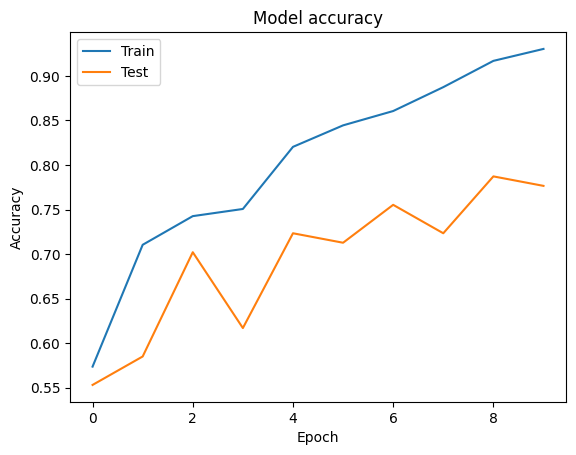

In [251]:
# Plot training & validation accuracy values
plt.plot(RNN_history.history['accuracy'])
plt.plot(RNN_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

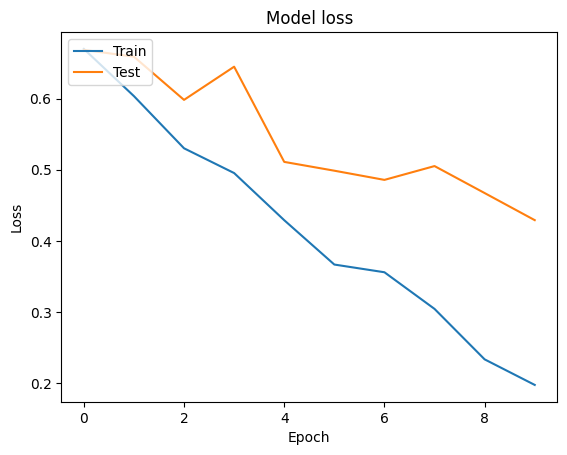

In [252]:
# Plot training & validation loss values
plt.plot(RNN_history.history['loss'])
plt.plot(RNN_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

3/3 [==============================] - 1s 7ms/step


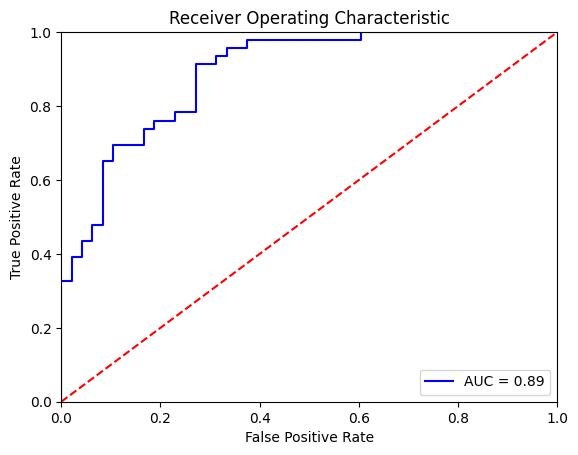

In [253]:
y_pred_RNN = RNN_model.predict(feature_test)
fpr, tpr, threshold = roc_curve(y_test, y_pred_RNN)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Pre-train model word embedding (Future work)

7. Instead of building word embedding ourselves, we can also use pre-trained
model (for example, sentence Bert) to extract key sentences of each summary. If
you use one of pre-trained models, compare the performance of your
classification model in the test set with the model using your own word
embedding.

In [113]:
! pip install transformers


In [114]:
from transformers import BertModel, BertTokenizer


In [115]:
fund_names, summaries = get_data(SUMMARY_PATH)
fund_names

['AB Arizona Portfolio',
 'AB Asia ex-Japan Equity Portfolio',
 'AB Bond Inflation Strategy',
 'AB Balanced Wealth Strategy Portfolio',
 'AB Credit Long/Short Portfolio',
 'AB All Market Income Portfolio',
 'AB All Market Real Return Portfolio',
 'AB Discovery Value Fund',
 'AB Dynamic Asset Allocation Portfolio',
 'AB FlexFee Emerging Markets Growth Portfolio',
 'AB FlexFee Core Opportunities Portfolio',
 'AB FlexFee International Strategic Core Portfolio',
 'AB Global Risk Allocation-Moderate Portfolio',
 'AB FlexFee Large Cap Growth Portfolio',
 'AB Global Thematic Growth Portfolio',
 'AB Income Fund',
 'AB Limited Duration High Income Portfolio',
 'AB Intermediate Bond Portfolio',
 'AB Minnesota Portfolio',
 'AB Massachusetts Portfolio',
 'AB Municipal Bond Inflation Strategy',
 'AB Tax-Aware Fixed Income Portfolio',
 'AB New York Portfolio',
 'AB New Jersey Portfolio',
 'AB Pennsylvania Portfolio',
 'AB Small Cap Value Portfolio',
 'AB Real Estate Investment Portfolio',
 'AB Small

In [116]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
input_ids = tokenizer.encode("mutual fund summary.", add_special_tokens=True)

text_words_pre_trained = tokenizer.convert_ids_to_tokens(input_ids)
print(text_words_pre_trained)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

['[CLS]', 'example', 'mutual', 'fund', 'summary', '.', '[SEP]']
